In [1]:
import numpy as np
import cv2 as cv
import tensorflow as tf
import os
import matplotlib.pyplot as plt

# Load images

Loading the images. A couple things happening here: firstly, the labelled area is a funny shape. So we need to use a perspective transform to warp it to a square. But we also want to be able to have the input slightly larger than the mask in order to avoid errors from the edges. Should end up with 512x512 input, 492x492 output.

In [2]:
#trying to use all masks
mask_dict = {}
mask_dict["land_mask"] = cv.imread("new-masks/land_mask.jpg")
mask_dict["marsh_mask"] = cv.imread("new-masks/marsh_mask.jpg")
mask_dict["pond_mask"] = cv.imread("new-masks/pond_mask.jpg")
mask_dict["openwater_mask"] = cv.imread("new-masks/openwater_mask.jpg")



four_class_mask = cv.imread("new-masks/4class_mask.jpg")

print(mask_dict["land_mask"].shape)

(2666, 3591, 3)


In [45]:
#load in the images, do perspective transforms
##need to figure out inverse of larger square. 


POINTS1=np.float32([[215,40],[895,65],[305,810],[930,780]])
#SIZE = 512
PAD = 24 #?
SIZE = 512 - 2*PAD
POINTS2 = np.float32([[0,0],[SIZE,0],[0,SIZE],[SIZE,SIZE]])
DIM=(1149,853)

M = cv.getPerspectiveTransform(POINTS1,POINTS2)
Minv = np.linalg.pinv(M)
#print(Minv)
PadPoints2= np.float32([[[-PAD,-PAD]],[[SIZE + PAD,-PAD]],[[-PAD,SIZE + PAD]],[[SIZE + PAD,SIZE + PAD]]])
ShiftPadPoints2 = np.float32([[0,0],[SIZE + 2*PAD,0],[0,SIZE + 2*PAD],[SIZE + 2*PAD,SIZE + 2*PAD]])

#see where the inverse image of the padded points was 
PadPoints1= cv.perspectiveTransform(PadPoints2,Minv)

#get a transformation from there to the new padded points, 
#which should just be the previous one plus a shift of (PAD,PAD).
Mpad = cv.getPerspectiveTransform(PadPoints1,ShiftPadPoints2)
#input will be 512 x 512, 

print(Mpad)
print(M)
#output will be 512-PAD x 512 - PAD.

#print(PAD1)

[[ 6.15516015e-01 -7.42836897e-02 -1.05980747e+02]
 [-2.24925664e-02  5.42170542e-01  6.53292441e+00]
 [-1.03519326e-04 -8.54112335e-05  1.00000000e+00]]
[[ 6.18000503e-01 -7.22338251e-02 -1.29980755e+02]
 [-2.00081043e-02  5.44220438e-01 -1.74670751e+01]
 [-1.03519317e-04 -8.54111816e-05  1.00000000e+00]]


In [4]:


#gray_mask = cv.warpPerspective(pre_gray_mask,M,(700,700))


def load_marsh_images(folder):
    images = []
    
    for i in range(1,12):
        img = cv.imread(os.path.join(folder,"Band%d.jpg" % i))
        print("Band%d.jpg" % i)
        if img is not None:
            #convert to black and white
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            #warp so the mask is square
            img = cv.warpPerspective(img,Mpad,(SIZE+2*PAD,SIZE+2*PAD))
            images.append(img)
        

    
    masks = []
    
    classes = len(mask_dict)
    
    for key in mask_dict.keys():
        mask = mask_dict[key]
        print(key)
        #fixing to greyscale seems helpful
        mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
        mask = cv.resize(mask, DIM, interpolation = cv.INTER_AREA)
        mask = cv.warpPerspective(mask,M,(SIZE,SIZE))
        masks.append(mask)
        
        
    images = np.array(images)
    masks = np.array(masks)
    
    #process masks to make them 1-hot
    
    masks = 255.0-masks
    ma = masks.max(axis=(1,2))
    masks = np.transpose(masks,(1,2,0))
    masks = masks/ma
    masks = masks.round(0)
    
    #add masks to get 4 class.
    print(np.array(range(classes)))
    FourClassMask = masks*np.array(range(classes))
    FourClassMask = np.max(FourClassMask,axis=2)
    FourClassMask = np.atleast_3d(FourClassMask)

    
    #masks = np.transpose(masks,(2,0,1))
    
    images = np.transpose(images,(1,2,0))/255.0

    return images,FourClassMask

In [46]:
images,masks = load_marsh_images("train_jpg")

Band1.jpg
Band2.jpg
Band3.jpg
Band4.jpg
Band5.jpg
Band6.jpg
Band7.jpg
Band8.jpg
Band9.jpg
Band10.jpg
Band11.jpg
land_mask
marsh_mask
pond_mask
openwater_mask
[0 1 2 3]


(512, 512, 11) (464, 464, 1)


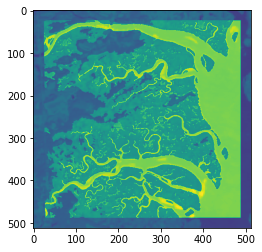

In [47]:
#overlay looks good. Maybe a bit off? hard to say.

print(images.shape,masks.shape)
plt.imshow(masks), plt.imshow(images[:,:,5])
#overlay to make sure they got it right.
s_img = masks[:,:,0]
l_img = images[:,:,6]
new_img = np.zeros_like(l_img)
x_offset=y_offset=PAD
new_img[:,:] = l_img[:,:]
new_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = new_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] + .5*s_img
plt.imshow(new_img)

In [290]:
np.histogram(masks)
#ponds are quite underrepresented.


(array([ 42573,      0,      0, 131971,      0,      0,  11862,      0,
             0,  75738]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]))

# VCR and GCE data

Loading the new data, dealing with funny mask shape by pixel-wise loss function. Also doing some augmentation.


In [6]:
#load masks
gce_mask = cv.imread("new-masks/updated_GCE_mask.jpg")
pie_mask = cv.imread("new-masks/updated_PIE_mask.jpg")
vcr_mask = cv.imread("new-masks/updated_VCR_map.jpg")

new_masks = [cv.cvtColor(gce_mask, cv.COLOR_BGR2GRAY), 
         cv.cvtColor(pie_mask, cv.COLOR_BGR2GRAY), 
         cv.cvtColor(vcr_mask, cv.COLOR_BGR2GRAY)]
masks = []
for m in new_masks:
    m = cv.resize(m,(YDIM,XDIM))
    masks.append(m)
new_masks = masks



In [230]:
new_masks[1].shape

(2048, 2816)

In [3]:
#load images; careful to do it in order
XDIM = 2048
YDIM = 11*XDIM//8

#might want to do 1024 x 1024 instead, idk.

def load_marsh_images(folder):
    images = []
    
    for i in range(1,12):
        img = cv.imread(os.path.join(folder,"Band%d.jpg" % i))
        #print("Band%d.jpg" % i)
        if img is not None:
            #convert to black and white
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            img = cv.resize(img,(YDIM, XDIM))
            #warp so the mask is square
            #img = cv.warpPerspective(img,Mpad,(SIZE+2*PAD,SIZE+2*PAD))
            images.append(img)
    return images


In [4]:
gce_imgs = load_marsh_images("train_jpg/GCE")
pie_imgs = load_marsh_images("train_jpg/PIE")
vcr_imgs = load_marsh_images("train_jpg/VCR")

In [158]:
#images = np.array([gce_imgs,pie_imgs,vcr_imgs])
pie_imgs[1].shape

(2666, 3591)

In [5]:
images = np.array([gce_imgs,pie_imgs,vcr_imgs])
images.shape
#pie_mask.shape

(3, 11, 2048, 2816)

## Exploring new data

<IPython.core.display.Javascript object>


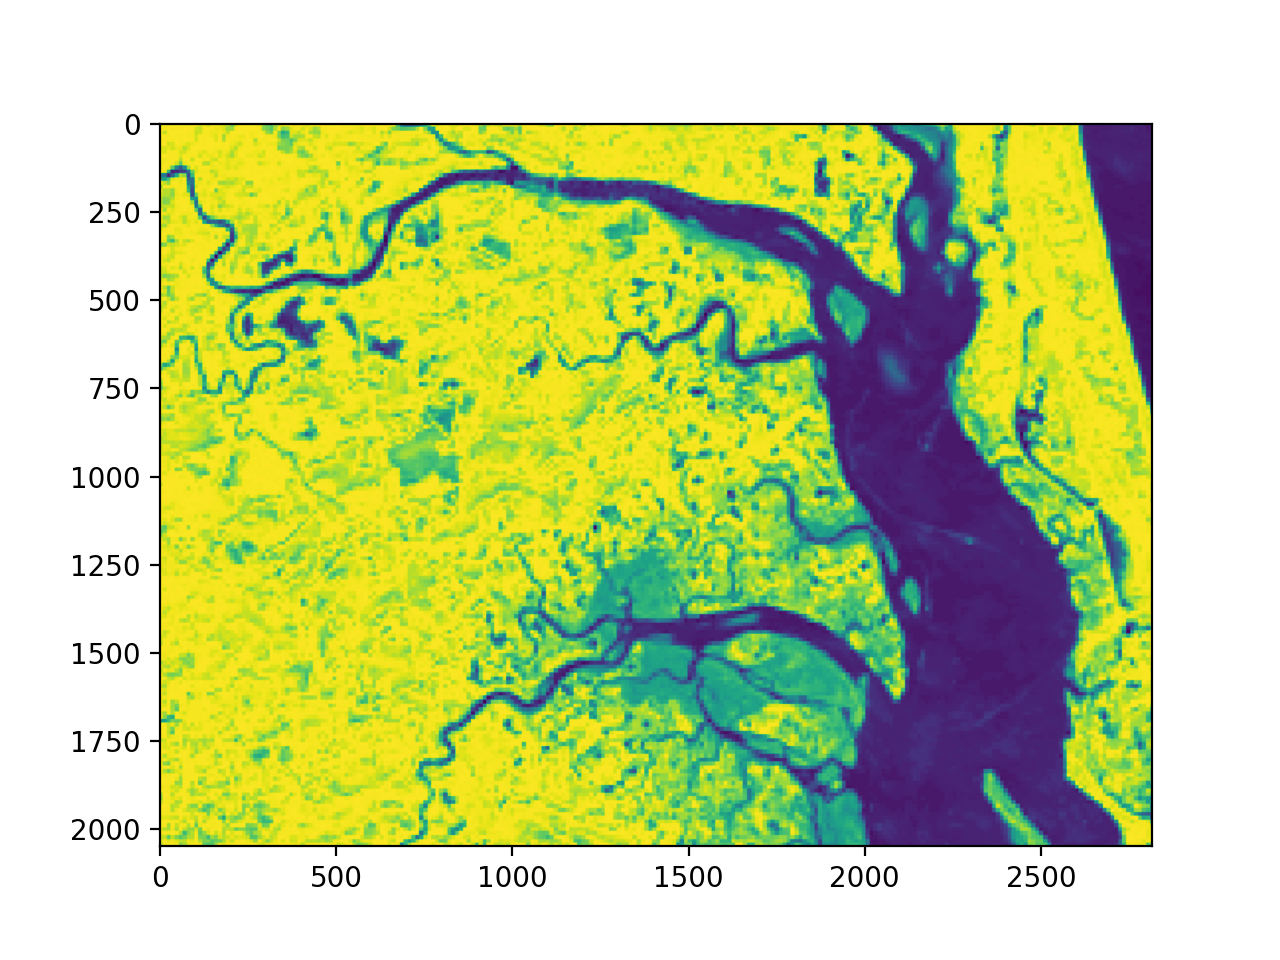

In [231]:
ax = plt.axes()

ax.imshow(pie_imgs[4])

In [102]:
#look at new data
#plt.imshow(gce_mask)
#plt.imshow(pie_mask)
ax = plt.axes()


ax.imshow(vcr_mask)
#plt.imshow(grey_vcr_mask)
#it shows in the notebook!




In [86]:
#plt.imshow(vcr_mask)

In [6]:
gce_mask[0,0,:]
#all 255's if not in mask


array([255, 255, 255], dtype=uint8)

In [73]:
# convert to integers. 
# is there a good automated way to do this? 
#let's try with gce mask.
#x = gce_mask.reshape([-1,3])
x = vcr_mask.reshape([-1,3])
x.shape
#H, edges = np.histogramdd(x)

y = np.unique(x,axis=0)

In [58]:
#why are there so many dang values in y?
y

array([[  0,   0, 228],
       [  0,   0, 229],
       [  0,   0, 230],
       ...,
       [255, 255, 252],
       [255, 255, 254],
       [255, 255, 255]], dtype=uint8)

In [71]:
from mpl_toolkits import mplot3d
%matplotlib notebook

<IPython.core.display.Javascript object>


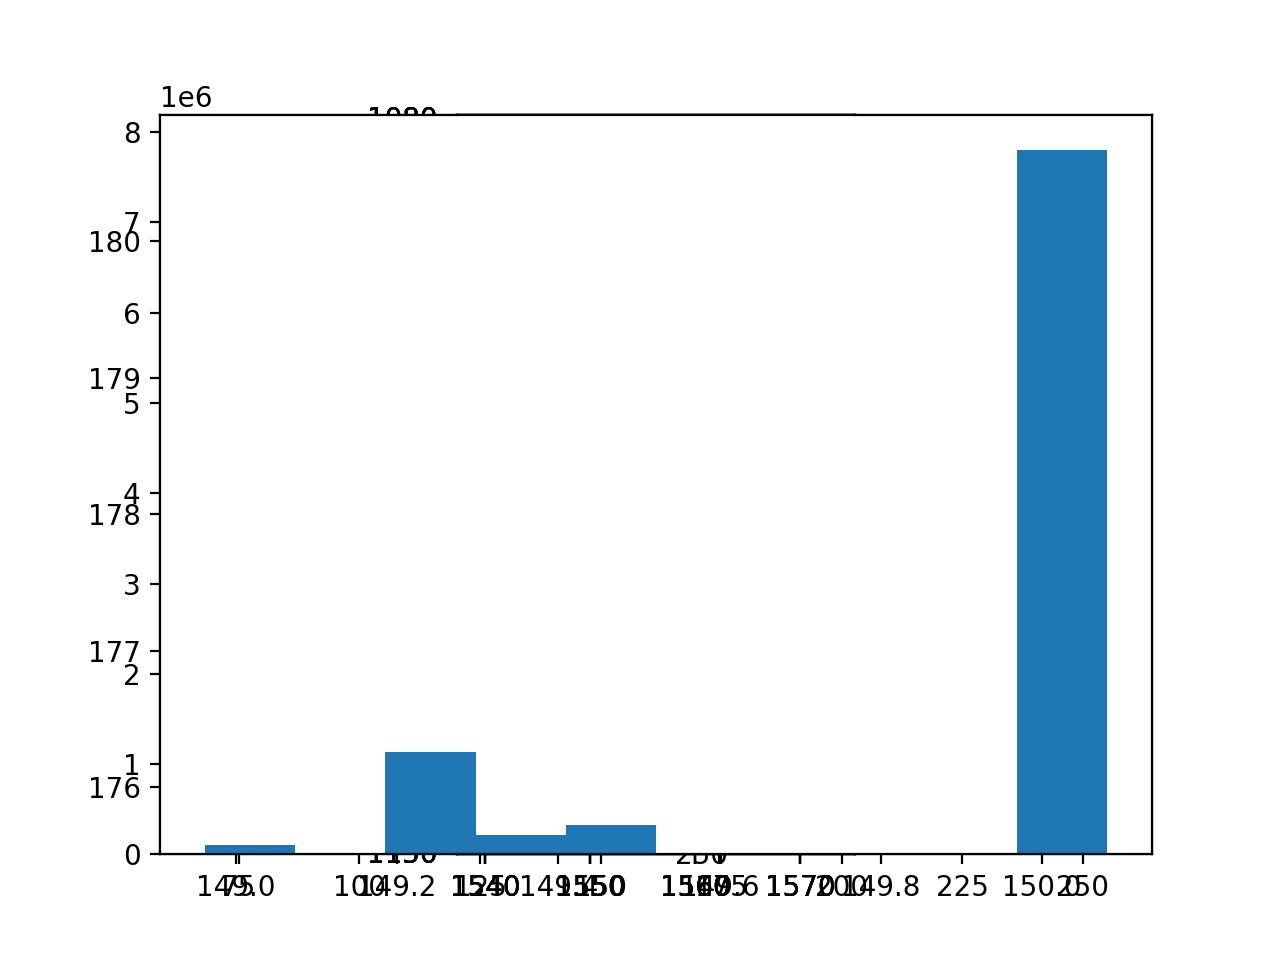

In [89]:
ax = plt.axes(projection='3d')
ax.scatter3D(y[:,0], y[:,1], y[:,2], c=y[:,2], cmap='Greens')

<IPython.core.display.Javascript object>


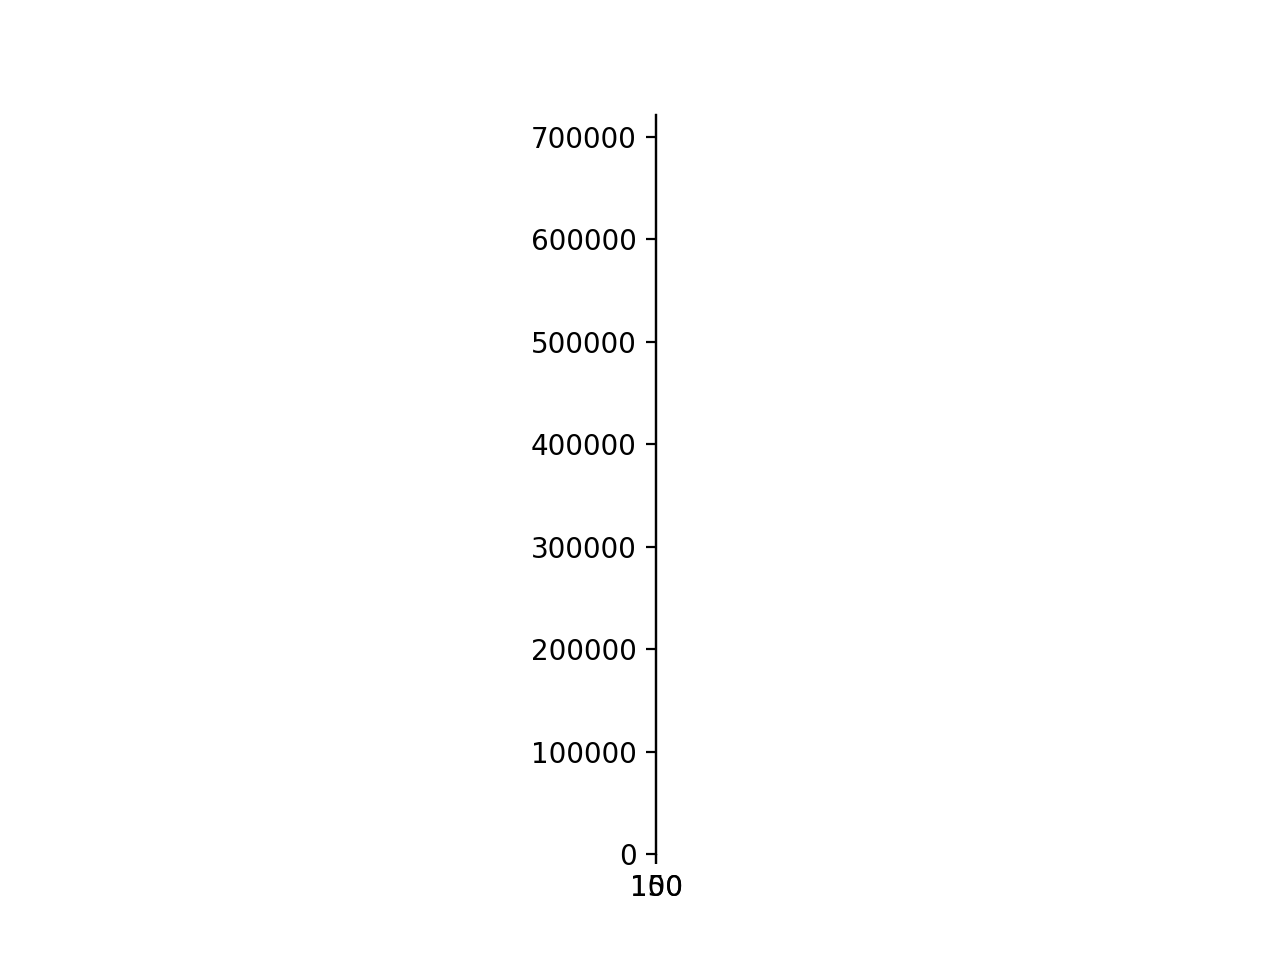

(array([5.870000e+02, 7.081800e+04, 1.468000e+04, 0.000000e+00,
        8.340000e+03, 4.099000e+03, 1.649000e+03, 0.000000e+00,
        4.419000e+03, 1.490000e+03, 7.300000e+01, 0.000000e+00,
        4.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 5.52

In [106]:
#z =  y @ np.array( [1,1,1])
#how to find this line that separates?? 
#try to choose a few points from a cluster, find a line that's orthogonal to that.

#idea: 
ax = plt.axes()
z = np.reshape(grey_vcr_mask,[-1])
#h = np.histogram(z)
#z = np.unique(z)
ax.hist(z,bins=255)
#manually: looks like 0: 0-90, 1: 90-125, 2:125-145, 3:145:180, beyond is unlabeled

In [107]:
u = np.unique(z)
u.shape

(84,)

In [115]:
#idea: for each threshold value, add 1 if it's greater than it.
#convert boolean to integer

p= grey_vcr_mask < 90
p.astype(int)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Making new masks

In [7]:
## want to set anything in specified range to a certain value. 
## Ideally would set up a piecewise constant function, then apply it entrywise to array
## What's the pythonic way to do this?

THRESH = [90,125,140,180]
masks = []
for mask in new_masks:
    int_mask = np.zeros_like(mask)
    for t in THRESH:
        is_bigger = mask >= t
        is_bigger = is_bigger.astype(int)
        int_mask = int_mask + is_bigger
    int_mask = np.reshape(int_mask, (1,XDIM,YDIM))
    masks.append(int_mask)
        
masks = np.array(masks)

In [340]:
masks.shape

(3, 1, 2048, 2816)

In [290]:
#check that it's right.

ax = plt.axes()

ax.imshow(test_masks[0,0])
#np.unique(int_masks)

## Test and train

I'm going to try a naive thing where I just convert the upper half of the mask to the unknown class.



In [8]:
te_masks = []
tr_masks = []



for m in masks:
    x = np.zeros_like(m)
    y = np.zeros_like(m)
    x.fill(4)
    y.fill(4)
    #x = x + m
    #y = y + m
    x[0,:XDIM//2,:]=m[0,:XDIM//2,:]
    #y[0,:YDIM//2,:]=4
    #x[0,YDIM//2:,:]=4
    y[0,XDIM//2:,:]=m[0,XDIM//2:,:]

    te_masks.append(x)
    tr_masks.append(y)

te_masks = np.array(te_masks)
tr_masks = np.array(tr_masks)
    


In [343]:
ax = plt.axes()

np.shape(te_masks)
#np.shape(tr_masks)

(3, 1, 2048, 2816)

In [368]:
plt.imshow(test_masks[0,0])

In [369]:
np.unique(te_masks)

array([0, 1, 2, 3, 4])

# Converting to dataset

In [9]:
images.shape, masks.shape

((3, 11, 2048, 2816), (3, 1, 2048, 2816))

In [9]:
def get_tensor(images):
    images_tensor = tf.convert_to_tensor(images,dtype =tf.float32)
    
    SAMPLES,BANDS,HEIGHT,WIDTH = images_tensor.shape
    #print(list(a))
    #b = [1]
    #b.extend(list(a))
    #image_tensor = tf.reshape(images_tensor,[SAMPLES,HEIGHT,WIDTH,BANDS])
    image_tensor = tf.transpose(images_tensor,[0,2,3,1])
    return image_tensor

In [34]:
#get the data 

train_images = get_tensor(images)
train_masks = get_tensor(tr_masks)

test_images = get_tensor(images)

test_masks = get_tensor(te_masks)



train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_masks))

test_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_masks))



train_batches = (
    train_dataset
    .cache()
    #.shuffle(BUFFER_SIZE)
    .batch(3)
    #.repeat()
    #.map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(3)

## Old Splits

Need to split data into a test and train image. Again, we want our output to be the mask over the part of the input that's at least 20 pixels away from the edge. This means that the masks for the test/train images will be 20 less than half of the size of the full mask, or $(512 - 2\cdot 20)/2 - 20 = 256 - 40= 216$. 

In [48]:
#old splits 
SPLIT_SIZE = 256
MASK_SPLIT_SIZE = SPLIT_SIZE-PAD
#=TEST_SIZE-PAD
#TEST_MASK_SIZE = TEST_SIZE - 2*PAD 

train_images = get_tensor(images[:SPLIT_SIZE,:,:])

test_images = get_tensor(images[SPLIT_SIZE:,:,:])

train_masks = get_tensor(masks[:(MASK_SPLIT_SIZE - PAD),:,:])

test_masks = get_tensor(masks[(MASK_SPLIT_SIZE + PAD):,:,:])

"""
train_images = get_tensor(images[:TEST_SIZE,:TEST_SIZE,:])

test_images = get_tensor(images[TEST_SIZE:,TEST_SIZE:,:])

train_masks = get_tensor(masks[:TEST_SIZE,:TEST_SIZE,:])

test_masks = get_tensor(masks[TEST_SIZE:,TEST_SIZE:,:])
"""



train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_masks))

#patch_dataset

test_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_masks))

#not sure why we need this anymore, but it doesn't work without it
train_batches = (
    train_dataset
    .cache()
    #.shuffle(BUFFER_SIZE)
    .batch(1)
    #.repeat()
    #.map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(1)

In [323]:
# make sure things look right 

test_images.shape,test_masks.shape
#output is supposed to be 216 x 472

#niow 240 x 496 - off by 24.

(TensorShape([3, 2048, 2816, 11]), (3, 1, 2048, 2816))

# New shallower model
I'm going to try a much shallower model. I predict that it won't be able to differentiate ponds from ocean, but otherwise that it will outperform the deep model.

In [11]:
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

## Results from previous models
1. depth 1 encoders: ?
2. depth 2 fully conv encoder/decoder; 5000 epochs .857 val accuracy
3. depth 2 enc/dec concat with a dilated conv. 3000 epochs .856 val accuracy. 
    * the "same" padding for the dilated convolution creates massive artifacts at the beginning. I fear the minimization just downweights the dilated conv layer to avoid this. Because I actually have much more image to work with, there should be a way to avoid this. Make my input and output sizes different, THEN use "same" padding.
4. kernel size from 2 to 4: 3000 epochs .79 val accuracy (more overfit).
5. using more of the image to avoid edge effects: still around .85 val accuracy, but faster training - got there after only 2000 epochs.
6. More channels? Wider - go up to 10. Not much benefit, slightly more overfitting - going back down to 5. Ummm, this did terribly - accuracy went down to 65 on val, and pretty bad on train too. Fluke? 
7. Remove dilated channel concat. Slower train, slightly worse fit.
8. Put back dilated channel all filters 5, dilated channel filter size only 2. Pretty ok - 83 val accuracy. Very few parameters, best in terms of simplicity. Welll... actually wihtout the dilated conv does just fine. Also - only train 2k epochs. 3k doesn't seem to help.
10. Increase depth? Made val accuracy worse (75 percent). Looks very "pixelated." Definitely need the skips.
11. Deeper and without the dilation - got a bit better, amusingly. like 82.
12. Add skips. Got worse - like 72. What the heck? Even training didn't crack 50. Somehow qualitatively not that bad, though.
13. Augmentations - not yet; haven't even fit the actual data yet.
14. Decrease stride to 1: Real bad, basically reversed marsh and water and all kinds of bad stuff. Honestly it's unclear why it even happened.
15. Add a stride 1 deconv at the end to avoid checkerboards - best so far .85. Still some checkerboarding in the ponds.
16. Added a skip for the input - improvement at  .86.
17. Increase first filter size: minor improvement, still at .86
18. Replaced stride 2 by max-pool - bloody awful. undid.
19. Replaced second filter by 4x4 filter - also terrible. undid, went back up.
20. Replaced the first conv2dTranspose by a 4x4; try to integrate more information. Terrible. 
21. Replace conv2dTranspose by dilated.




## More ideas to try 

1. Augmentation 
2. Rebalance classes; ponds underrepresented. Perhaps what's happening is that it's a local min to "not care about ponds"

In [ ]:
"""
#previous models 

#attempt no 1: just a single convolutional layer with filter 2x2 

#attempt no 2: encoder/decoder convolutional of depth 2, filters 2x2
#training for about 5000 epochs yielded val accuracy of .857

def shallow_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[None, None, 11])
    
    #down
    x = tf.keras.layers.Conv2D(filters=5,kernel_size=2,strides=2,activation="relu")(inputs)
    
    x = tf.keras.layers.Conv2D(10,2,2,activation="relu")(x)
    
    
    #up
    x = tf.keras.layers.Conv2DTranspose(5,2,2,activation="relu")(x)
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=2, strides=2,
    padding='same')
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)
    
#attempt no 3: depth 2 enc/dec concat with a dilated conv.

def shallow_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[None, None, 11])
    
    #down
    
    #convolutional
    x = tf.keras.layers.Conv2D(filters=5,kernel_size=2,strides=2,activation="relu")(inputs)
    
    
    #dilated convolution
    
    
    #usual convolution
    x = tf.keras.layers.Conv2D(filters=10,kernel_size=2,strides=2,activation="relu")(x)
    y = tf.keras.layers.Conv2D(filters=5,kernel_size=2,dilation_rate=10, padding="same",activation="relu")(x)
    
    #concat 
    concat = tf.keras.layers.Concatenate()
    x = concat([x,y])
    
    
    
    #up
    x = tf.keras.layers.Conv2DTranspose(5,2,2,activation="relu")(x)
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=2, strides=2,
    padding='same')
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)
    
#attempt no 4: increase filter sizes

def shallow_model(output_channels:int):
    #inputs = tf.keras.layers.Input(shape=[None, None, 11])
    
    #for debugging, fix input size
    inputs = tf.keras.layers.Input(shape=[256, 512, 11])
    
    #down
    
    #convolutional
    x = tf.keras.layers.Conv2D(filters=5,kernel_size=3,strides=2,activation="relu")(inputs)
    
    
    #dilated convolution
    
    
    #usual convolution
    x = tf.keras.layers.Conv2D(filters=10,kernel_size=3,strides=2,activation="relu")(x)
    y = tf.keras.layers.Conv2D(filters=5,kernel_size=3,dilation_rate=10, padding="same",activation="relu")(x)
    
    concat = tf.keras.layers.Concatenate()
    x = concat([x,y])
    
    
    
    #up
    x = tf.keras.layers.Conv2DTranspose(5,3,2,activation="relu")(x)
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=4, strides=2,activation="relu")
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)


"""

In [12]:
def shallow_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[XDIM, YDIM,11])
    
    #for debugging, fix input size
    #inputs = tf.keras.layers.Input(shape=[256, 512, 11])
    
    #down
    
    #first layer
    
    #convolutional
    x1 = tf.keras.layers.Conv2D(filters=5,kernel_size=4,strides=2,activation="relu",padding="same")(inputs)
    
    #second layer
    
    #usual convolution
    x2 = tf.keras.layers.Conv2D(filters=10,kernel_size=2,strides=2,activation="relu",padding="same")(x1)
    
    #maxpool
    #x2 = tf.keras.layers.MaxPooling2D(
    #pool_size=(2, 2), strides=None, padding="valid")(x2)
    
    
    """
    #dilated convolution
    y = tf.keras.layers.Conv2D(filters=5,kernel_size=2,dilation_rate=8, padding="valid",activation="relu")(x)
    
    #crop x to be same size as y so concat makes sense 
    #if x has shape x1,x2 and y has shape y1,y2 we want 
    #the part of x that starts at ((x1-y1)/2, (x2-y2)/2) and ends at ((x_1 + y_1)/2, (x_2 + y_2)/2)
    #i.e. the "middle y" of x.
    xdim1,xdim2 = x.shape[1],x.shape[2]
    ydim1,ydim2 = y.shape[1],y.shape[2]
    crop1 = (xdim1-ydim1)//2
    crop2 = (xdim2-ydim2)//2
    x = tf.keras.layers.Cropping2D(cropping=((crop1, crop2), (crop1, crop2)))(x)
    #need to make x,y same size before concatenating - simply cut off some of x?
    x = concat([x,y])
    """
    
    #third layer 
    
    x = tf.keras.layers.Conv2D(filters=10,kernel_size=2,strides=2,activation="relu",padding="same")(x2)
    #x = concat([x,x2])
    
    #up fourth layer
    
    x = tf.keras.layers.Conv2DTranspose(10,2,2,activation="relu",padding="same")(x)
    
    concat = tf.keras.layers.Concatenate()

    x = concat([x,x2])
    #fifth layer
    
    #dilation
    #x = tf.keras.layers.Conv2DTranspose(5,2,dilation_rate=2,activation="relu",padding="same")(x)
    #then upsample
    x = tf.keras.layers.Conv2DTranspose(5,2,2,activation="relu",padding="same")(x)
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=5, kernel_size=2, strides=2,activation="relu")
    concat = tf.keras.layers.Concatenate()
    x = concat([x,x1])
    
    x=last(x)
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=2, strides=1, padding="same",activation="relu")
    
    concat = tf.keras.layers.Concatenate()
    x = concat([x,inputs])   
    x = last(x)
    
    #crop to correct output shape 
    
    #xdim1,xdim2 = x.shape[1],x.shape[2]
    #ydim1,ydim2 = y.shape[1],y.shape[2]
    #crop1 = (xdim1-ydim1)//2
    #crop2 = (xdim2-ydim2)//2
    #x = tf.keras.layers.Cropping2D(cropping=((PAD, PAD), (PAD, PAD)))(x)
    #need to make x,y same size before concatenating - simply cut off some of x?
    #x = concat([x,y])
    
    return tf.keras.Model(inputs=inputs, outputs=x)
    


In [310]:
# testing dilated convolution 
z = tf.keras.layers.Conv2D(filters=10,kernel_size=3,strides=1,dilation_rate = 1,padding="same",activation="relu")(sample_image[tf.newaxis, ...])
#y = tf.keras.layers.Conv2D(filters=10,kernel_size=3,dilation_rate = 5,padding="same",activation="relu")(sample_image[tf.newaxis, ...])
#list(z.shape)
tf.keras.layers.Cropping2D(cropping=(((xdim1-ydim1)//2, (xdim2-ydim2)//2), ((xdim1+ydim1)//2, (xdim2+ydim2)//2)))(x)
z.shape[1]
#,y.shape

NameError: name 'xdim1' is not defined

In [46]:
#OUTPUT_CLASSES = 4
OUTPUT_CLASSES=5


#if we do 4 classes, I guess we'll need to set the loss to CategoricalCrossentropy. 
#But does pix2pix even work with that? It seemed to not work earlier. 
model = shallow_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#better to figure out pad later on to get the right image size. 16 less than orig - so pad =8?

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2048, 2816,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 1408, 5 885         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 704, 10) 210         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 352, 10) 410         conv2d_1[0][0]                   
______________________________________________________________________________________________

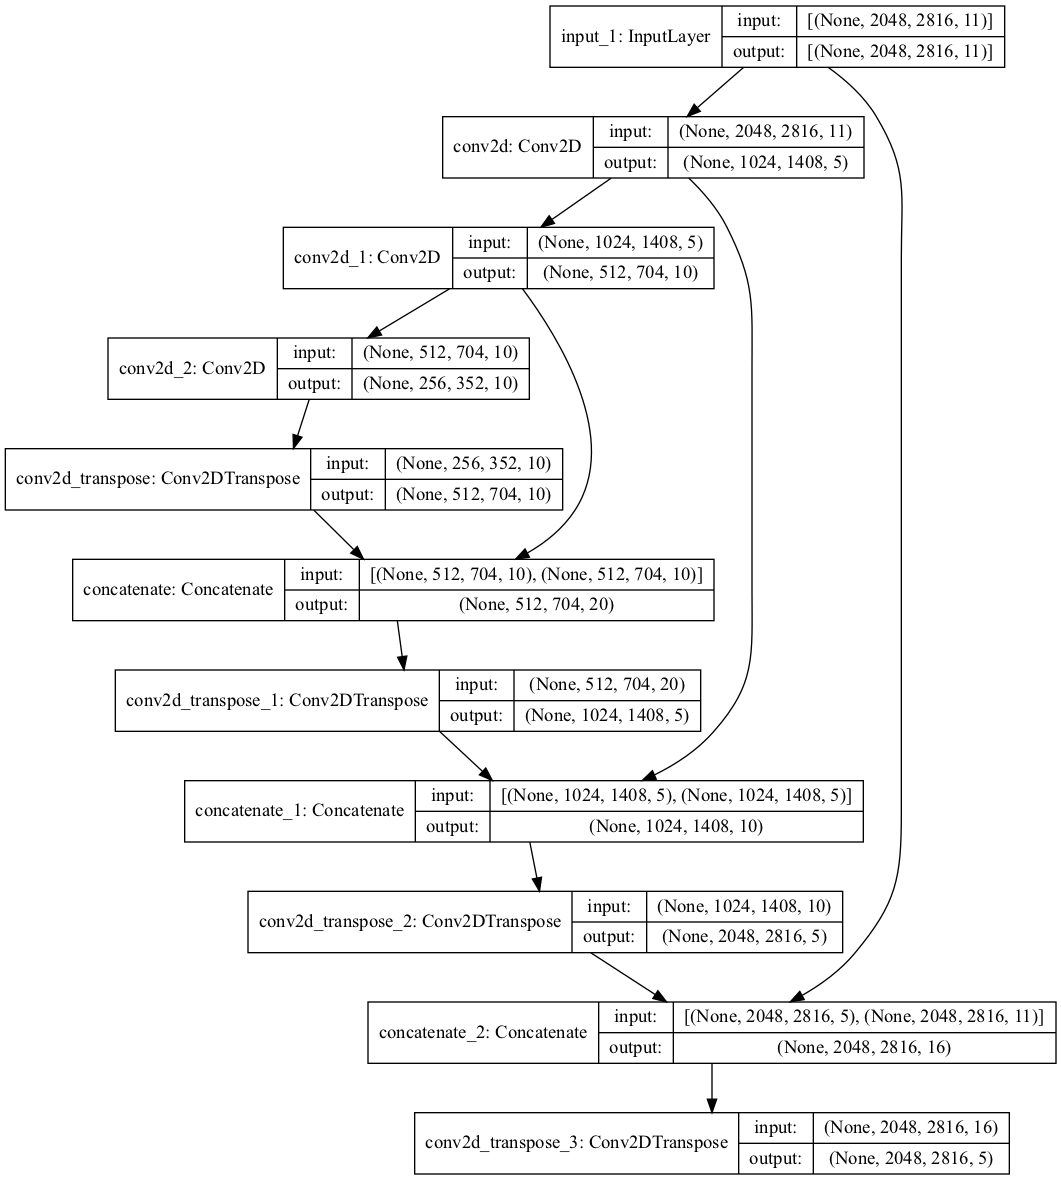

In [15]:
#256-208 = 48. try pad=24?
tf.keras.utils.plot_model(model, show_shapes=True)

# Old mobilenet model
I used the same neural network from the tutorial but with a 1x1 convolution to change the number of channels.

In [12]:
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

In [44]:
#tried to use mobilenet with more channels, got issues.

base_model = tf.keras.applications.MobileNetV2(input_shape=[None, None, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [45]:

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [46]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[None, None, 11])

    #try to do a 1x1 convolution to get it down to size.
    #reduce_channel = tf.keras.layers.Conv2D(3,1,1,activation="relu")(inputs)
    reduce_channel = tf.keras.layers.Conv2D(3,1,1,activation="relu")(inputs)
  # Downsampling through the model
    #skips = down_stack(inputs)
    skips = down_stack(reduce_channel)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [176]:
#OUTPUT_CLASSES = 4
OUTPUT_CLASSES=4


#if we do 4 classes, I guess we'll need to set the loss to CategoricalCrossentropy. 
#But does pix2pix even work with that? It seemed to not work earlier. 
model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

NameError: name 'unet_model' is not defined

In [49]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 36          input_2[0][0]                    
__________________________________________________________________________________________________
model (Functional)              [(None, None, None,  1841984     conv2d[0][0]                     
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 5 1476608     model[0][4]                      
____________________________________________________________________________________________

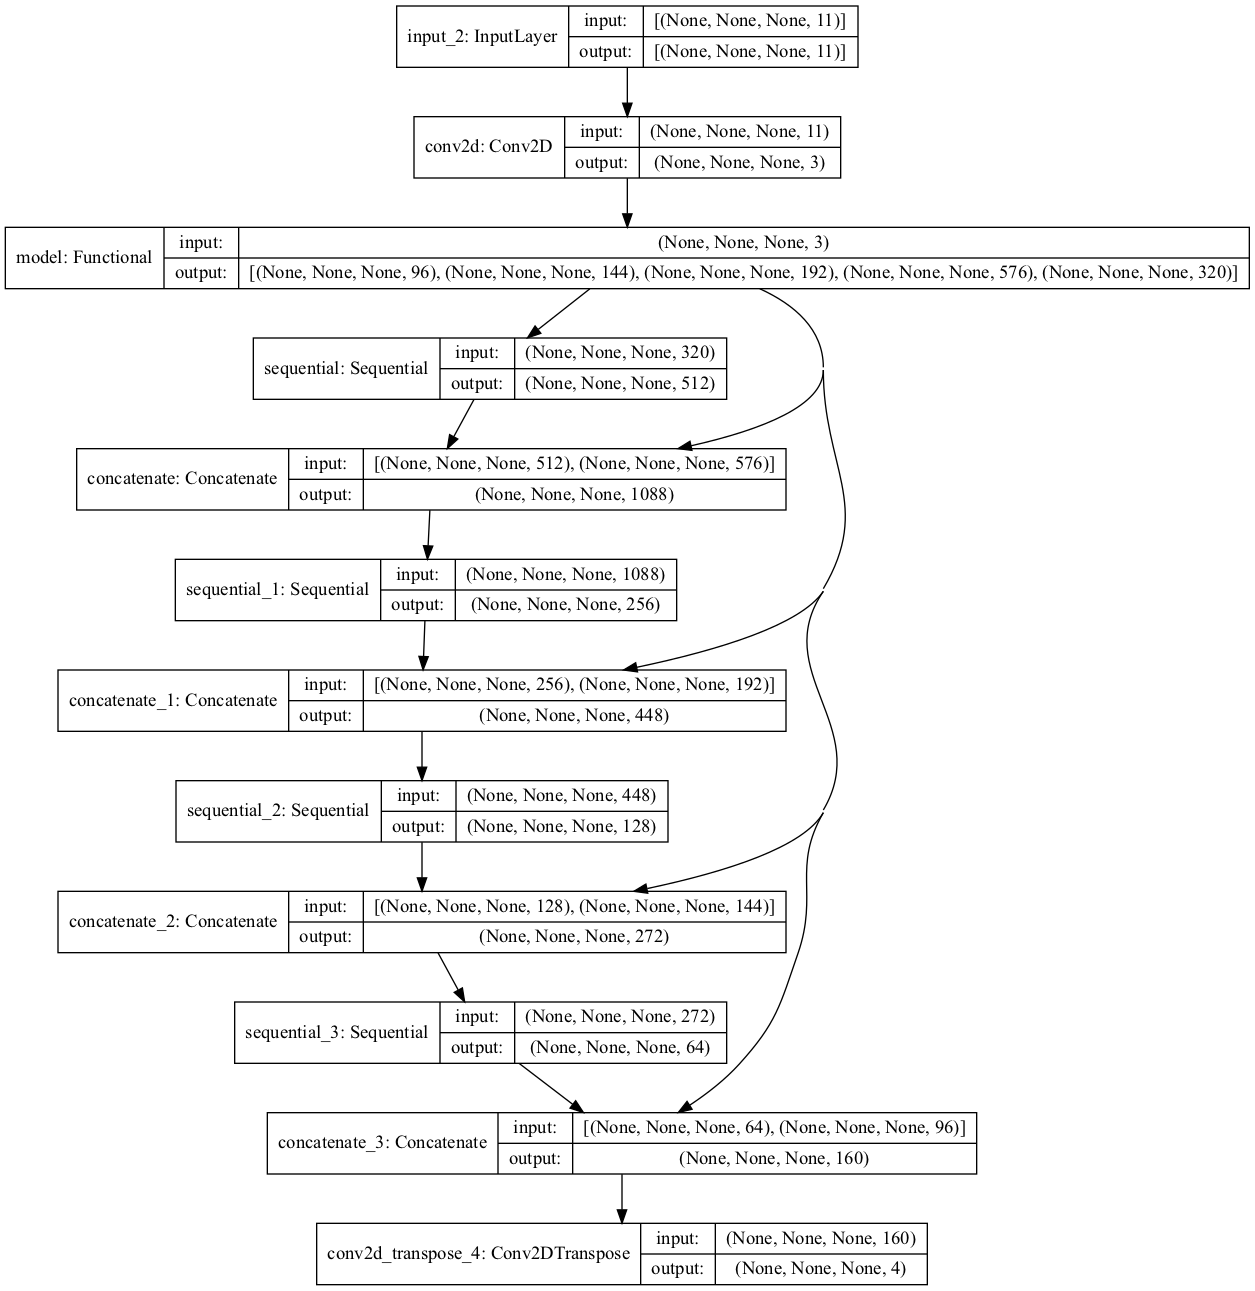

In [122]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Testing the model

Try out the model to check what it predicts before training.

In [16]:
for image,mask in test_dataset.take(1):
    sample_image,sample_mask = image, mask

In [17]:
for image,mask in train_dataset.take(1):
    sample_train_image,sample_train_mask = image, mask

In [20]:
sample_image.shape,sample_mask.shape

(TensorShape([2048, 2816, 11]), TensorShape([2048, 2816, 1]))

In [18]:
#to show the 
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image, mask[0,0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

def show_train_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0,0], create_mask(pred_mask)])
  else:
    display([sample_train_image, sample_train_mask,
             create_mask(model.predict(sample_train_image[tf.newaxis, ...]))])
    
def show_predictions_loaded(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = loaded_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(loaded_model.predict(sample_image[tf.newaxis, ...]))])
    
def display(display_list):
  plt.figure(figsize=(20, 20))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1,len(display_list),i+1)
    plt.title(title[i])
    if display_list[i].shape[-1]==1:
        mi = 0
        ma = 3
    else:
        mi = 4
        ma = 7
    plt.imshow(tf.keras.utils.array_to_img(display_list[i][:,:,mi:ma]))
    plt.axis('off')
  plt.show()

2022-05-08 21:17:01.082334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


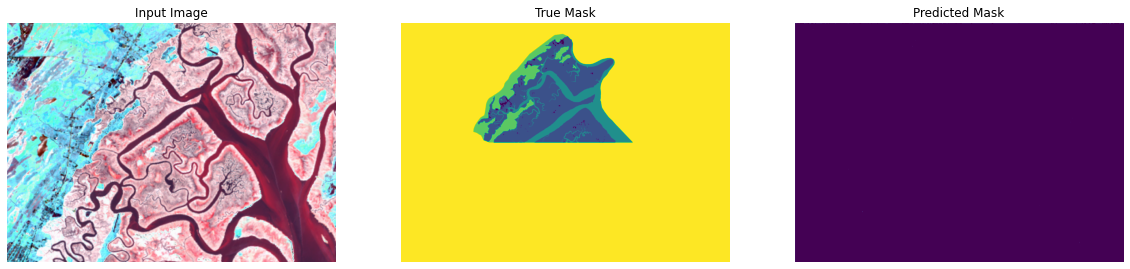

In [39]:
show_predictions()

# Training the model

In [47]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5==0:
        clear_output(wait=True)
        show_predictions()
    #show_train_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
tb_callback = tf.keras.callbacks.TensorBoard('./logs/NewData1000', update_freq=1)

2022-05-08 21:22:08.179518: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-05-08 21:22:08.179593: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-05-08 21:22:08.180465: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.


In [29]:
## adding sample weights so that the final class is ignored 

def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([1,1,1,1, 0.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [49]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 2048, 2816, 11), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2048, 2816, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2048, 2816, 1), dtype=tf.float32, name=None))

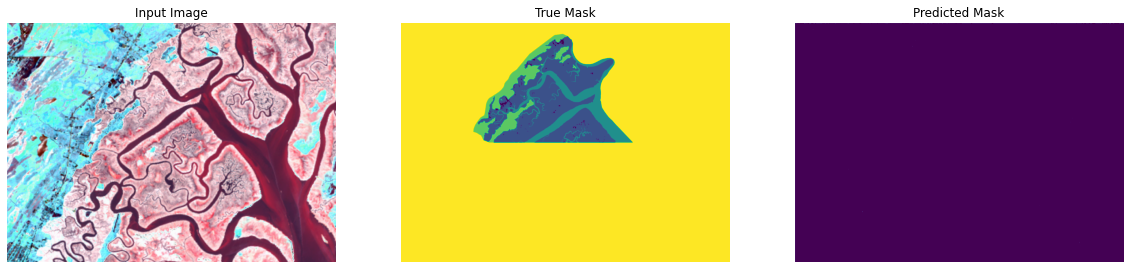


Sample Prediction after epoch 496

Epoch 497/500
1/1 [==============================] - 4s 4s/step - loss: 0.0787 - accuracy: 0.0048 - val_loss: 0.0915 - val_accuracy: 0.0027

Sample Prediction after epoch 497

Epoch 498/500
1/1 [==============================] - 4s 4s/step - loss: 0.0787 - accuracy: 0.0048 - val_loss: 0.0915 - val_accuracy: 0.0027

Sample Prediction after epoch 498

Epoch 499/500
1/1 [==============================] - 4s 4s/step - loss: 0.0787 - accuracy: 0.0048 - val_loss: 0.0915 - val_accuracy: 0.0027

Sample Prediction after epoch 499

Epoch 500/500
1/1 [==============================] - 4s 4s/step - loss: 0.0787 - accuracy: 0.0048 - val_loss: 0.0915 - val_accuracy: 0.0027

Sample Prediction after epoch 500



In [48]:
#actually training 

EPOCHS = 500
#VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

#get validation working!

model_history = model.fit(train_batches.map(add_sample_weights), 
                          epochs=EPOCHS,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches.map(add_sample_weights),
                          callbacks=[DisplayCallback(),tb_callback]
                         )

In [37]:
%reload_ext tensorboard

In [49]:
%tensorboard --logdir logs/

# saving/loading

In [196]:
model.save('saved-model-unpatched')

2022-03-04 14:56:46.599334: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved-model-unpatched/assets


In [ ]:
loaded_model = tf.keras.models.load_model('saved-model-unpatched')

In [ ]:
show_predictions_loaded()